In [46]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import urllib.request
import pybedtools
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

import cytograph as cg
from cytograph.plotting import doublets_plots
from cytograph.decomposition import HPF
from scipy.stats import poisson
from cytograph.manifold import BalancedKNN
from cytograph.metrics import jensen_shannon_distance
# from cytograph.embedding import tsne
from cytograph.clustering import PolishedLouvain, PolishedSurprise
from cytograph.plotting import manifold

sys.path.append('/home/camiel/chromograph')
from chromograph.plotting.QC_plot import QC_plot
from chromograph.pipeline.TF_IDF import TF_IDF

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *
import pickle

from sklearn.decomposition import IncrementalPCA

import logging

from pynndescent import NNDescent
from scipy import sparse
from cytograph.metrics import jensen_shannon_distance
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from unidip import UniDip
from sklearn.ensemble import IsolationForest

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [50]:
proportion_artificial = 0.091
qc_dir = '/data/proj/scATAC/chromograph/doublets_test'
name = '10X_242_1_test'
fixed_th = None
k = None
max_th = 1

/home/camiel/cytograph-dev/cytograph/plotting/doublets_plots.py:49: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale = 1, frameon = False, fontsize=10)
14:31:35 INFO     Doublet fraction: 7.56%, 827 cells. 
			(Expected detectable doublet fraction: 5.47%)


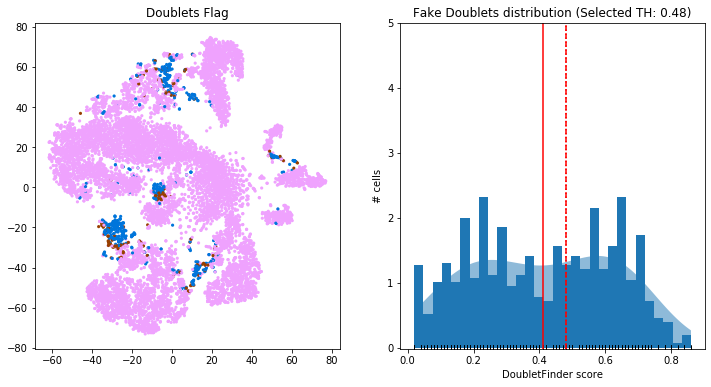

In [57]:
f = '/data/proj/scATAC/samples/10X242_1/10X242_1_5kb.loom'
f2 = '/data/proj/scATAC/chromograph/doublets_test/10X242_1_test.loom'
with loompy.connect(f, 'r+') as ds:
    n_real_cells = ds.shape[1]
    n_doublets = int(n_real_cells / (1 - proportion_artificial) - n_real_cells)    

    with loompy.connect(f2, 'r+') as dsout:
        pca, k, knn_result, knn_dist, knn_idx, knn_result1, knn_dist1, knn_idx1, knn_dist_rc, knn_idx_rc = pickle.load(open('/data/proj/scATAC/chromograph/doublets_test/doublets.pkl', 'rb'))
            
        dist_th = np.mean(knn_dist1.flatten()) + 1.64 * np.std(knn_dist1.flatten())

        doublet_freq = np.logical_and(knn_idx > ds.shape[1], knn_dist < dist_th)
        doublet_freq_A = doublet_freq[ds.shape[1]:ds.shape[1]+n_doublets, :]
        mean1 = doublet_freq_A.mean(axis=1)
        mean2 = doublet_freq_A[:, 0:int(np.ceil(k / 2))].mean(axis=1)
        doublet_score_A = np.maximum(mean1, mean2)

        doublet_freq = doublet_freq[0:ds.shape[1], :]
        mean1 = doublet_freq.mean(axis=1)
        mean2 = doublet_freq[:, 0:int(np.ceil(k / 2))].mean(axis=1)
        doublet_score = np.maximum(mean1, mean2)
        doublet_flag = np.zeros(ds.shape[1],int)
        doublet_th1 = 1
        doublet_th2 = 1
        doublet_th = 1
        #Infer TH from the data or use fixed TH

        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=0.1  , kernel='gaussian')
        kde.fit(doublet_score_A[:, None])

        # score_samples returns the log of the probability density
        xx = np.linspace(doublet_score_A.min(), doublet_score_A.max(), len(doublet_score_A)).reshape(-1,1)

        logprob = kde.score_samples(xx)
        if fixed_th is not None:
            doublet_th = float(fixed_th)
            
        else:
            #Check if the distribution is bimodal
            intervals = UniDip(np.exp(logprob)).run()
            if (len(intervals)>1):
                kmeans = KMeans(n_clusters=2).fit(doublet_score_A.reshape(len(doublet_score_A),1))
                high_cluster = np.where(kmeans.cluster_centers_==max(kmeans.cluster_centers_))[0][0]
                doublet_th1 = np.around(np.min(doublet_score_A[kmeans.labels_==high_cluster]),decimals=3)

            #0.5% for every 1000 cells - the rate of detectable doublets by 10X 
            doublet_th2 = np.percentile(doublet_score,100-(5e-4*ds.shape[1]))
            doublet_th2 = np.around(doublet_th2,decimals=3)
            #The TH shouldn't be higher than indicated
            if  doublet_th2 >max_th:
                doublet_th2= max_th
            if  doublet_th1 >max_th:
                doublet_th1= max_th
            if (len(np.where(doublet_score>=doublet_th1)[0])>(len(np.where(doublet_score>=doublet_th2)[0]))):
                doublet_th = doublet_th2
            else:
                doublet_th = doublet_th1
        doublet_flag[doublet_score>=doublet_th]=1
        
        #Calculate the score for the cells that are nn of the marked doublets 
        pca_rc = pca[0:n_real_cells, :]
        knn_dist1_rc, knn_idx1_rc = knn_result1.kneighbors(X=pca_rc[doublet_flag==1,:],n_neighbors=10, return_distance=True)
        
        dist_th = np.mean(knn_dist1_rc.flatten()) + 1.64 * np.std(knn_dist1_rc.flatten())
        doublet2_freq = np.logical_and(doublet_flag[knn_idx_rc]==1  , knn_dist_rc < dist_th)
        doublet2_nn =  knn_dist_rc < dist_th
        doublet2_score  = doublet2_freq.sum(axis=1)/doublet2_nn.sum(axis=1)

        doublet_flag[np.logical_and(doublet_flag == 0 ,doublet2_score >= doublet_th/2)] = 2
        
        ds.ca.PCA = pca[0:ds.shape[1], :]
        
        fig, ax = plt.subplots(1, 2, figsize=(12,6))
        doublets_plots.doublets_TSNE(ax[0], ds, doublet_flag)
        doublets_plots.fake_doublets_dist(ax[1], doublet_score_A, logprob, xx, doublet_th1, doublet_th2, doublet_th)
        fig.savefig(os.path.join('/data/proj/scATAC/chromograph/doublets_test', 'doublet_plot.png'), dpi=144)
        logging.info(f"Doublet fraction: {100*len(np.where(doublet_flag>0)[0])/ds.shape[1]:.2f}%, {len(np.where(doublet_flag>0)[0])} cells. \n\t\t\t(Expected detectable doublet fraction: {(5e-4*ds.shape[1]):.2f}%)")
	return doublet_score,doublet_flag

In [14]:
f = '/Users/camima/data/scATAC/10X242_1_5kb.loom'
with loompy.connect(f, 'r') as ds:    
    ## Create n doublets
    n_doublets = 1000
    doublets = np.zeros((ds.shape[0], n_doublets))
    db_tot = np.zeros(n_doublets)
    
#     logging.info('Creating data')
#     ## Create doublets
#     for i in range(n_doublets):
#         a = np.random.choice(ds.shape[1])
#         b = np.random.choice(ds.shape[1])
#         doublets[:, i] = ds[:, a] + ds[:, b]
#         db_tot[i] = ds.ca['passed_filters'][a] + ds.ca['passed_filters'][b]
#         if i%100 ==0:
#             logging.info(f'{i} completed')
            
    ## Use only Q25 top bins
    logging.info(f'Calculating row wise nonzero rate')
    NCells = ds.map([np.count_nonzero], axis=0)[0]
    q = np.quantile(NCells, .75)
    logging.info(f'Using only bins present in more than {q} cells')
    valid = NCells > q
    
#     data = np.concatenate((ds[valid,:], doublets[valid,:]), axis=1)
#     logging.info(f'Test data has {data.shape} shape')

#     cas = {'CellID': np.concatenate([ds.ca['CellID'], np.array(['_'.join(['doublet', str(x)]) for x in range(n_doublets)])]),
#            'Cell': np.concatenate([[1] * ds.shape[1], [0] * n_doublets])}

12:19:11 INFO     Calculating row wise nonzero rate
12:20:44 INFO     Using only bins present in more than 251.0 cells


In [ ]:
## Calculate TF_IDF and fit PCA

logging.info(f'Performing TF-IDF')
tf_idf = TF_IDF()
tf_idf.fit(data)
X = tf_idf.transform(data)

# X = np.zeros(data.shape)
# for (ix, selection, view) in ds.scan(axis=1):
#     X[:,selection] = tf_idf.transform(view[:,:], selection)
#     logging.info(f'transformed {max(selection)} cells')
ds.layers['TF_IDF'] = X.astype('float16')
self.blayer = 'TF_IDF'

In [ ]:
k = None
use_pca = True

if k is None:
    k = int(np.min([100, ds.shape[1] * 0.01]))

logging.info(f"Initialize NN structure with k = {k}")
if use_pca:
    knn_result = NearestNeighbors(n_neighbors=k, metric='euclidean', n_jobs=4)
    knn_result.fit(pca)
    knn_dist, knn_idx = knn_result.kneighbors(X=pca, return_distance=True)

    num = ds.shape[1]
    knn_result1 = NearestNeighbors(n_neighbors=k, metric='euclidean', n_jobs=4)
    knn_result1.fit(pca[0:num, :])
    knn_dist1, knn_idx1 = knn_result1.kneighbors(X=pca[num + 1:, :], n_neighbors=10)
    knn_dist_rc, knn_idx_rc = knn_result1.kneighbors(X=pca[0:num, :], return_distance=True)